C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


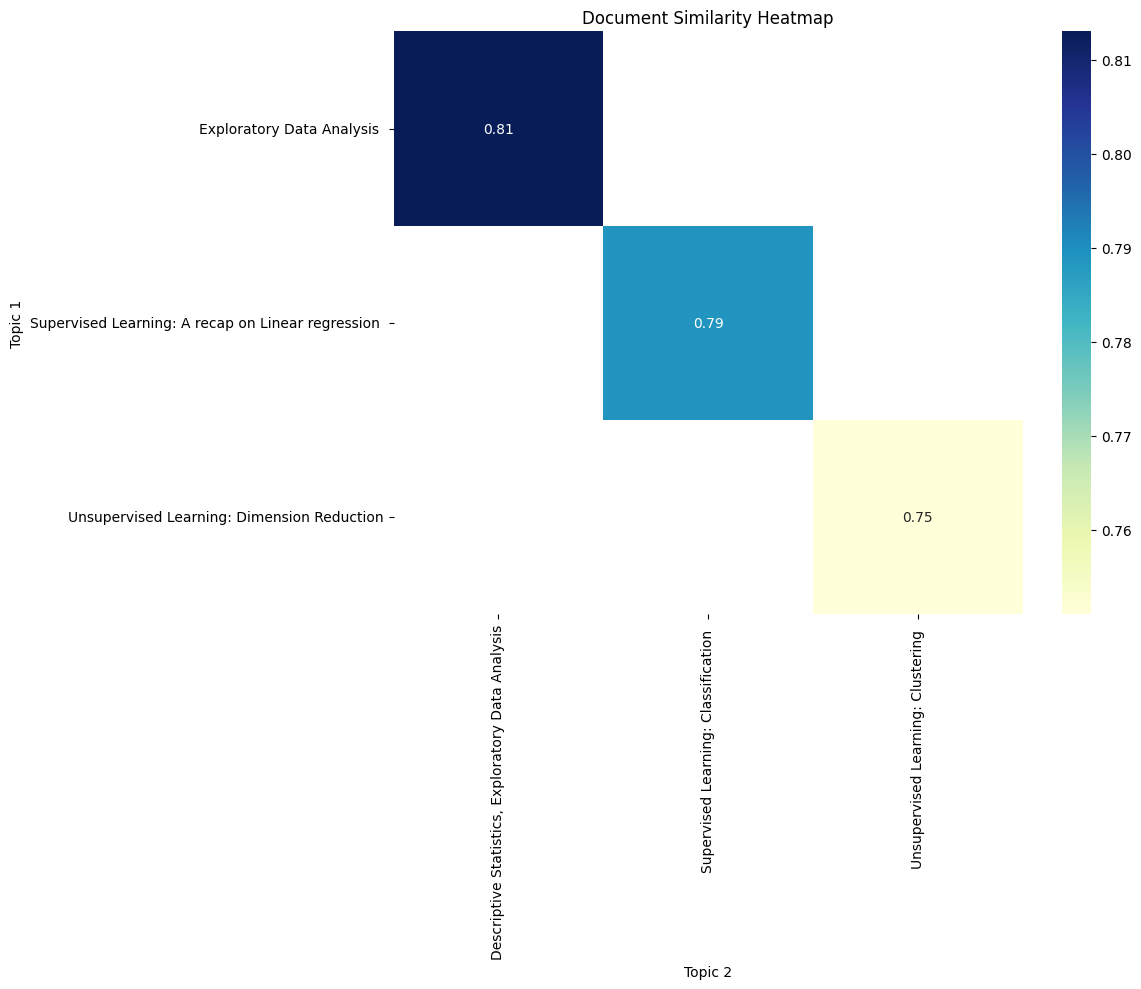

In [ ]:
import os
import pandas as pd
from docx import Document
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

# 1. خواندن فایل‌های DOCX از پوشه
def read_docx_files(folder_path):
    docx_files = [f for f in os.listdir(folder_path) if f.endswith('.docx')]
    doc_texts = {}
    
    for file in docx_files:
        # بارگذاری هر فایل docx
        doc = Document(os.path.join(folder_path, file))
        full_text = "\n".join([para.text for para in doc.paragraphs if para.text.strip() != ""])
        doc_texts[file] = full_text
    
    return doc_texts

# 2. بارگذاری داده‌های اکسل با ساختار جدید
df = pd.read_excel('C:/Users/Nastaran/Desktop/UniversityConstructor/semester4/Final 08042025/Data/similar_topics_above_50.xlsx')  # فایل اکسل خودت رو جایگزین کن
df = df[['Topic_1', 'Course_1', 'Topic_2', 'Course_2']]  # اطمینان از انتخاب ستون‌های مناسب

# 3. مدل پیش‌فرض برای مشابه‌سازی
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# 4. خواندن فایل‌های DOCX از پوشه مشخص
folder_path = 'C:/Users/Nastaran/Desktop/UniversityConstructor/semester4/Final 08042025/Data/Similarity'  # مسیر پوشه‌ای که فایل‌های docx در آن است
docx_texts = read_docx_files(folder_path)

# 5. ایجاد جدول شباهت‌ها از مقایسه عناوین
similar_pairs = []
threshold = 0.7  # میزان شباهت برای انتخاب جفت‌ها

for _, row in df.iterrows():
    topic1, course1 = row['Topic_1'], row['Course_1']
    topic2, course2 = row['Topic_2'], row['Course_2']
    
    # چک کردن شباهت
    similarity_score = util.pytorch_cos_sim(
        model.encode([topic1, topic2], convert_to_tensor=True)[0],
        model.encode([topic1, topic2], convert_to_tensor=True)[1]
    ).cpu().numpy()[0][0]
    
    if similarity_score > threshold:
        # ذخیره عنوان‌ها و شباهت
        similar_pairs.append({
            'Topic 1': topic1,
            'Course 1': course1,
            'Topic 2': topic2,
            'Course 2': course2,
            'Similarity': round(similarity_score, 3)
        })

# 6. نمایش شباهت‌ها در یک DataFrame
similar_df = pd.DataFrame(similar_pairs)

# 7. ذخیره نتایج در فایل Excel
similar_df.to_excel("C:/Users/Nastaran/Desktop/UniversityConstructor/semester4/Final 08042025/Data/docx_similarity_results.xlsx", index=False)

# 8. پیدا کردن فایل‌های مرتبط با هر جفت عنوان مشابه
for _, row in similar_df.iterrows():
    topic1, topic2 = row['Topic 1'], row['Topic 2']
    # پیدا کردن فایل‌های مرتبط به این دو عنوان
    files_topic1 = [f for f in docx_texts.keys() if topic1.lower() in f.lower()]
    files_topic2 = [f for f in docx_texts.keys() if topic2.lower() in f.lower()]
    
    # اگر فایل‌ها پیدا شدند، محتویاتشان را مقایسه کنیم
    if files_topic1 and files_topic2:
        file1 = files_topic1[0]
        file2 = files_topic2[0]
        
        # مقایسه محتوای فایل‌ها
        text1 = docx_texts[file1]
        text2 = docx_texts[file2]
        
        similarity_score = util.pytorch_cos_sim(
            model.encode([text1, text2], convert_to_tensor=True)[0],
            model.encode([text1, text2], convert_to_tensor=True)[1]
        ).cpu().numpy()[0][0]
        
        # چاپ نتیجه مشابهت محتوا
        print(f"Similarity between {file1} and {file2}: {similarity_score:.3f}")
        
        # ذخیره نتیجه در فایل Excel
        similar_df.loc[similar_df['Topic 1'] == topic1, 'File 1'] = file1
        similar_df.loc[similar_df['Topic 2'] == topic2, 'File 2'] = file2
        similar_df.loc[similar_df['Topic 1'] == topic1, 'Content Similarity'] = similarity_score

# 9. ذخیره نتایج نهایی در فایل Excel
similar_df.to_excel("C:/Users/Nastaran/Desktop/UniversityConstructor/semester4/Final 08042025/Data/final_docx_comparison_results.xlsx", index=False)

# 10. رسم نمودار Heatmap برای شباهت‌ها
plt.figure(figsize=(12, 10))
sns.heatmap(similar_df.pivot_table(index='Topic 1', columns='Topic 2', values='Similarity'), cmap="YlGnBu", annot=True)
plt.title("Document Similarity Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("docx_similarity_heatmap.png")
plt.show()
